In [48]:
## Load environment variables from a .env file
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGSMITH_API_KEY"]= os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING", "true")
os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT", "https://api.langsmith.com")

### This step is Optional Just to show the LLM is working by making Groq Call

In [49]:
## Install necessary packages and import modules
from langchain_groq import ChatGroq
from langchain_classic.agents import AgentExecutor
from langchain_classic.agents.react.agent import create_react_agent
from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser

llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

# Pull the react prompt from LangChain hub
prompt = hub.pull("hwchase17/react")

print(prompt)

# Create the agent (with empty tools list)
agent = prompt | llm | StrOutputParser()

result = agent.invoke( {"input":"What is the capital of France?",
                        "tools": [],"agent_scratchpad": "","tool_names": []})


print(result)

input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'} template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}'
Question: What is the capital of France?
Thought: The capital city of France is well‑known and commonly referenced.
Final Answer: Pari

## Buidling Retrievers for RAG to optimize the queries

In [50]:
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma


# Example usage of RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=200)

sources = {
        "anti_patterns": "playbook/SQL_anti_pattern.pdf",
        "databricks": "playbook/Optimize_Databricks_Queries_overcast.pdf",
        "spark": "playbook/spark_perf_tunning.pdf"
    }

split_documents_list = []
for source_name, pdf_path in sources.items():
    # Example usage of PyPDFLoader
    pdf_loader = PyPDFLoader(pdf_path)  # Replace with actual PDF path
    pdf_documents = pdf_loader.load()
    for d in pdf_documents:
        d.metadata["source"] = source_name

    doc_splits = text_splitter.split_documents(pdf_documents)
    split_documents_list.extend(doc_splits)
    embd = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    Chroma.from_documents(
            doc_splits,
            embd,
            persist_directory=f"./chroma/{source_name}"
        )

In [52]:
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import JSONLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
import json
from langchain_core.documents import Document

# Example usage of RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=50)


# Example usage of JSONLoader
json_loader = JSONLoader(
    file_path="stats/table_stats.json",
    jq_schema=".[]",
    text_content=False)  # Replace with actual JSON path
json_documents = json_loader.load()

# Convert to new Documents with descriptive text
new_documents = []
for doc in json_documents:
    data = json.loads(doc.page_content)
    # Assuming JSON has keys: table_name, rows, partitioned_by
    page_content = f"Table {data.get('table', 'unknown')} has {data.get('row_count', 'unknown')} rows, partitioned by {data.get('partition_cols', 'unknown')} and size {data.get('size_mb', 'unknown')} mb."
    metadata = {"category": "table_stats"}
    new_doc = Document(page_content=page_content, metadata=metadata)
    new_documents.append(new_doc)

print(f"Number of JSON documents loaded: {len(new_documents)}")
doc_splits = text_splitter.split_documents(new_documents)
embd = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
# Add to vectorstore
vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=embd
)

print(f"Number of documents in vectorstore: {vectorstore.index.ntotal}")
table_stats_retriever = vectorstore.as_retriever()

# Example retrieval
#query = "provide table names ?"
#results = table_stats_retriever.invoke(query, k=2)
#for i, doc in enumerate(results):
#    print(f"\nDocument {i+1}:\n{doc.page_content}\n")

Number of JSON documents loaded: 2
Number of documents in vectorstore: 2


In [54]:
from langchain_community.vectorstores import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

def load_retriever(name):
    embd = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    db = Chroma(
        persist_directory=f"./chroma/{name}",
        embedding_function=embd
    )
    return db.as_retriever(search_kwargs={"k": 4})

# Example usage
#retriever = load_retriever("anti_patterns")
#retriever.invoke("What is select * anti-patterns?")
#!/usr/bin/env python3


## Tools and Agents

### Defining Langraph State
#### Using the Pydantic as the state class for the implicit validation

In [137]:
from pydantic import BaseModel, Field
from typing import List, Dict, Optional, Any
from datetime import datetime

# ---------- Core Input ----------
# This will be captured from system.query_history of Databricks
class QueryMetadata(BaseModel):
    user_name: str
    statement_text: str
    status: str
    start_time: datetime
    end_time: datetime
    warehouse_id: Optional[str] = None
    error_message: Optional[str] = None


# ---------- RAG Document ----------

class RagDocument(BaseModel):
    content: str
    source: str
    score: Optional[float] = None


# ---------- Slowness Scoring ----------

class SlownessScore(BaseModel):
    duration_seconds: float
    normalized_score: float = Field(
        ge=0.0,
        le=1.0,
        description="0 = fast, 1 = very slow"
    )
    reason: Optional[str] = None


# ---------- Optimization Output ----------

class OptimizationResult(BaseModel):
    needs_optimization: bool
    result: Optional[str] = None
    optimized_query: Optional[str] = None
    suggestions: List[str]
    applied_rules: List[str]


# ---------- Self Evaluation ----------

class SelfEvaluation(BaseModel):
    correctness: float = Field(ge=0.0, le=1.0)
    performance_gain_estimate: float = Field(ge=0.0, le=1.0)
    faithfulness: float = Field(ge=0.0, le=1.0)
    comments: Optional[str] = None
    results: Optional[str] = None


# ---------- Adaptive RAG Control ----------

class RagStrategy(BaseModel):
    retrievers_used: List[str]
    retriever_weights: Dict[str, float]
    rerank: bool = False
    expanded_search: bool = False


# ---------- Main LangGraph State ----------

class QueryOptimizerState(BaseModel):
    # Input
    query: QueryMetadata

    # Derived
    slowness: Optional[SlownessScore] = None

    # RAG
    rag_context: List[RagDocument] = []
    rag_strategy: RagStrategy = RagStrategy(
        retrievers_used=[],
        retriever_weights={}
    )

    # Optimization
    optimization: Optional[OptimizationResult] = None

    # Evaluation
    self_eval: Optional[SelfEvaluation] = None

    # Control flags
    iteration: int = 0
    max_iterations: int = 2
    terminate: bool = False
    context: List[Any] = []

### This measures the slowness of the input query

In [138]:
def slowness_score(state):
    duration = (state.query.end_time - state.query.start_time).total_seconds()
    # Simple heuristic: normalize duration to a score between 0 and 1
    if duration < 1:
        norm_score = 0.0
    elif duration > 60:
        norm_score = 1.0
    else:
        norm_score = duration / 60.0

    reason = ""
    if duration > 30:
        reason = "Query took longer than 30 seconds."
    elif duration > 10:
        reason = "Query took longer than 10 seconds."
        
    print("--- CALCULATING SLOWNESS SCORE ---")
        
    print(f"Slowness duration: {duration} seconds, normalized score: {norm_score}, reason: {reason}")
        
    slowness_score =  SlownessScore(
        duration_seconds=duration,
        normalized_score=norm_score,
        reason=reason
    )
    state.slowness = slowness_score
    return state

### Adaptive RAG Retreiver

In [139]:
def retrieve_context(state):
    query = state.query.statement_text
    print(f"Retrieving context for query: {query} and slowness score: {state.slowness.normalized_score}")
    score = state.slowness.normalized_score

    retrievers = ["anti_patterns", "spark"]
    if score > 0.6:
        retrievers += ["databricks"]

    context = []
    for r in retrievers:
        docs = load_retriever(r).invoke(query)
        context.extend(docs)
        
    stats_doc = table_stats_retriever.invoke(query, k=2)
    context.extend(stats_doc)
    print("--- RETRIEVING CONTEXT DOCUMENTS ---")
    state.context = context
    print(f"Retrieved {len(context)} context documents.")
    # print("Top documents:")
    #for doc in context[:3]:   
    #    print(f"- {doc.page_content[:100]}... (source: {doc.metadata.get('source', 'unknown')})")
    return state


### Optimization Agent

In [140]:
from langchain_groq import ChatGroq
import json

def optimize_query(state):

    llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

    prompt = f"""
    You are a Databricks SQL optimization expert.\n
    Query:\n
    {state.query.statement_text}\n
    Context:\n
    {state.context}\n\n
    Tasks:\n
    1. Should this query be optimized?\n
    2. Rewrite query if needed\n
    3. Provide optimization suggestions\n
    Return JSON with keys: needs_optimization (bool), optimized_query (str or null), suggestions (list of str), applied_rules (list of str)
    also provide the original query result as 'result' field.
    """

    result = llm.invoke(prompt)
    print("--- OPTIMIZATION STEP ---")
    #print(result.content)

    # Parse the JSON response
    content = result.content.strip()
    if content.startswith('```json'):
        content = content[7:]  # Remove ```json
    if content.endswith('```'):
        content = content[:-3]  # Remove ```
    content = content.strip()

    try:
        data = json.loads(content)
        optimizationResult = OptimizationResult(**data)
        optimizationResult.result = result.content
    except json.JSONDecodeError as e:
        print(f"JSON parsing error: {e}")
        # Fallback
        optimizationResult = OptimizationResult(
            needs_optimization=True,
            result=result.content,
            optimized_query=None,
            suggestions=[result.content],
            applied_rules=[]
        )

    state.optimization = optimizationResult
    return state

### Self Evaluation Agent
### Based on the Optiization Agent it does the self Evaluation on the result

In [141]:
from langchain_groq import ChatGroq
import json

def self_evaluate(state):
    llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)
    eval_prompt = f"""
       Evaluate the following optimization:\n

       {state.optimization.result}\n\n

        Score from 0 to 1 for:\n
        - Correctness in float range 0.0 to 1.0 where 0.0 is incorrect and 1.0 is fully correct\n
        - Practical usefulness in float range 0.0 to 1.0 where 0.0 is not useful and 1.0 is very useful\n
        - performance_gain_estimate in float range 0.0 to 1.0 where 0.0 is no gain and 1.0 is significant gain\n
        - comments: any additional remarks

        Return JSON with keys: correctness, practical_usefulness, performance_gain_estimate, comments
        """

    response = llm.invoke(eval_prompt)
    print("--- SELF-EVALUATION STEP ---")
   # print(response.content)

    # Parse the JSON response
    content = response.content.strip()
    if content.startswith('```json'):
        content = content[7:]  # Remove ```json
    if content.endswith('```'):
        content = content[:-3]  # Remove ```
    content = content.strip()

    try:
        data = json.loads(content)
        self_eval = SelfEvaluation(
            correctness=data.get("correctness", 0.0),
            faithfulness=data.get("practical_usefulness", 0.0),  # Map practical_usefulness to faithfulness
            performance_gain_estimate=data.get("performance_gain_estimate", 0.0),
            comments=data.get("comments"),
            results=response.content
        )
    except json.JSONDecodeError as e:
        print(f"JSON parsing error in self_evaluate: {e}")
        # Fallback
        self_eval = SelfEvaluation(
            correctness=0.5,
            faithfulness=0.5,
            performance_gain_estimate=0.5,
            comments="Parsing failed",
            results=response.content
        )

    state.self_eval = self_eval
    return state

## Langraph Setup

In [142]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(QueryOptimizerState)

graph.add_node("score", slowness_score)
graph.add_node("retrieve", retrieve_context)
graph.add_node("optimize", optimize_query)
graph.add_node("evaluate", self_evaluate)

# Build graph
graph.add_edge(START, "score")
graph.add_edge("score", "retrieve")
graph.add_edge("retrieve", "optimize")
graph.add_edge("optimize", "evaluate")

app = graph.compile()





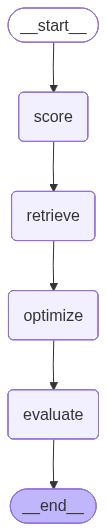

In [143]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [148]:
if __name__ == "__main__":
    import json
    # Example input
    query_metadata = QueryMetadata(
        user_name="alice",
        statement_text="SELECT * FROM orders WHERE amount > 1000",
        status="SUCCESS",
        start_time=datetime(2025,1,1,10,0,0),
        end_time= datetime(2025,1,1,10,6,0)
    )

    initial_state = QueryOptimizerState(query=query_metadata)

    final_state = app.invoke(initial_state)
    
   
    
    print("\n\n=== FINAL OUTPUT ===")
    print(f"SlownessScore : {final_state["slowness"].normalized_score} and reason : {final_state["slowness"].reason} ")
    print(f"Optimization Needed : {final_state["optimization"].needs_optimization}" )
    print(f"Final Optimized Query : {final_state["optimization"].optimized_query}" )
    print(f"Optimization Suggestions : {final_state["optimization"].suggestions}" ) 
    print(f"Self Evaluation Correctness : {final_state["self_eval"].correctness}" )
    print(f"Self Evaluation Correctness : {final_state["self_eval"].comments}" )

   # print("Final State:")
   # print(json.dumps(final_state, indent=2, default=str))

--- CALCULATING SLOWNESS SCORE ---
Slowness duration: 360.0 seconds, normalized score: 1.0, reason: Query took longer than 30 seconds.
Retrieving context for query: SELECT * FROM orders WHERE amount > 1000 and slowness score: 1.0
--- RETRIEVING CONTEXT DOCUMENTS ---
Retrieved 14 context documents.
--- OPTIMIZATION STEP ---
--- SELF-EVALUATION STEP ---


=== FINAL OUTPUT ===
SlownessScore : 1.0 and reason : Query took longer than 30 seconds. 
Optimization Needed : True
Final Optimized Query : SELECT order_id, order_date, amount, customer_id
FROM orders
WHERE amount > 1000;
Optimization Suggestions : ['Avoid SELECT * – list only the columns you actually need (column pruning).', 'If you frequently filter on `amount`, consider clustering the table on that column (e.g., Z‑ordering) to improve predicate push‑down.', 'Enable Adaptive Query Execution (AQE) in Databricks to let Spark dynamically choose the best join and shuffle strategies at runtime.', 'Make sure table statistics are up‑to‑date